In [68]:
import os
import re
import nibabel as nib
from nibabel.affines import apply_affine
import numpy.linalg as npl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [14]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
# slice_0 = t2s_img_data[int(t2s_img_data.shape[0]/2), :, :]
# slice_1 = t2s_img_data[:, int(t2s_img_data.shape[1]/2), :]
# slice_2 = t2s_img_data[:, :, int(t2s_img_data.shape[2]/2)]
# show_slices([slice_0, slice_1, slice_2])

### Reading in Patch Data

In [144]:
root_dir = os.path.join('Data', 'SCSeg')
subjects = os.listdir(root_dir)
lesion_data = {}; t2_data = {}; t2s_data = {}; n_lesions = {};

for subj in subjects:
    lesion_img = nib.load(os.path.join(root_dir, subj, 'SC', 'labelLesion.nii.gz'))
    lesion_img_data = lesion_img.get_fdata()
    n_lesions[subj] = max(np.unique(lesion_img_data.ravel()))

    res_dir = os.path.join(root_dir, subj, 'SC', 'res')
    lesion_data[subj] = np.load(os.path.join(res_dir, 'patches_lesion.npy'))
    t2_data[subj]     = np.load(os.path.join(res_dir, 'patches_t2.npy'))
    t2s_data[subj]    = np.load(os.path.join(res_dir, 'patches_t2s.npy'))
        
    if not (lesion_data[subj].shape == t2_data[subj].shape) & (lesion_data[subj].shape == t2s_data[subj].shape):
        print('Different shapes for subj {}:\n\tLesion: {}, T2: {}, T2*: {}'.format(subj, lesion.shape, t2.shape, t2s.shape))

In [3]:
# Collapse all patches into one Numpy array.
patches_lesion = np.concatenate(list(lesion_data.values()))
patches_t2 = np.concatenate(list(t2_data.values()))
patches_t2s = np.concatenate(list(t2s_data.values()))
# Record which subject corresponds to which patch
patches_subjects = [subj for subj in subjects for i in range(0,lesion_data[subj].shape[0])]

print("Total Patches: {}\n Lesion Patches:{}\n T2 Patches: \t{}\n T2* Patches: \t{}".format(len(patches_subjects), patches_lesion.shape, patches_t2.shape, patches_t2s.shape))

Total Patches: 419
 Lesion Patches:(419, 48, 48, 48)
 T2 Patches: 	(419, 48, 48, 48)
 T2* Patches: 	(419, 48, 48, 48)


In [164]:
list(lesion_data.keys())

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '57',
 '58',
 '59',
 '6',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '8',
 '9']

### Summarising Lesion & Patch Data

Text(0.5, 1.0, '# of Lesions per Subject')

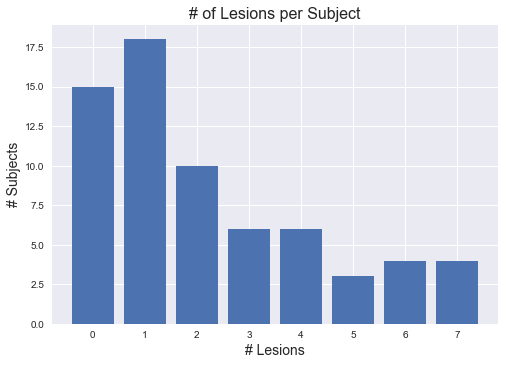

In [156]:
lesion_count = np.unique(list(n_lesions.values()), return_counts=True)
plt.bar(lesion_count[0], lesion_count[1])
plt.xlabel('# Lesions', fontsize=14)
plt.ylabel('# Subjects', fontsize=14)
plt.title('# of Lesions per Subject', fontsize=16)

In [124]:
lesion_voxel_count = np.unique(patches_lesion, return_counts=True)[1]
lesion_voxel_prop = lesion_voxel_count[1]/sum(lesion_voxel_count)
print('Overall in the dataset, {}% of voxels contain a lesion.\n\t({} voxels out of a total {})'.format(
    round(lesion_voxel_prop*100, 3), lesion_voxel_count[1], sum(lesion_voxel_count)))

lesion_voxel_raw_count_patches = [np.unique(patch, return_counts=True)[1] for patch in patches_lesion]
lesion_voxel_count_patches = [0 if len(x)==1 else x[1] for x in lesion_voxel_raw_count_patches]
lesion_voxel_prop_patches = [0 if len(x)==1 else x[1]/sum(x) for x in lesion_voxel_raw_count_patches]
total_voxel_count_patches = [sum(x) for x in lesion_voxel_raw_count_patches]

df_patch_count = pd.DataFrame(zip(patches_subjects, lesion_voxel_prop_patches, lesion_voxel_count_patches, total_voxel_count_patches), 
                              columns=['subject', 'prop_lesion', 'voxels_lesion', 'total_voxels'])

Overall in the dataset, 0.421% of voxels contain a lesion.
	(195160 voxels out of a total 46338048)


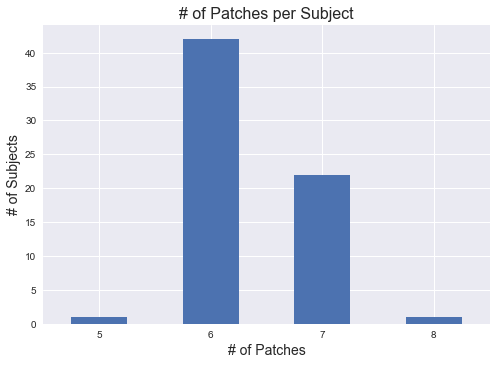

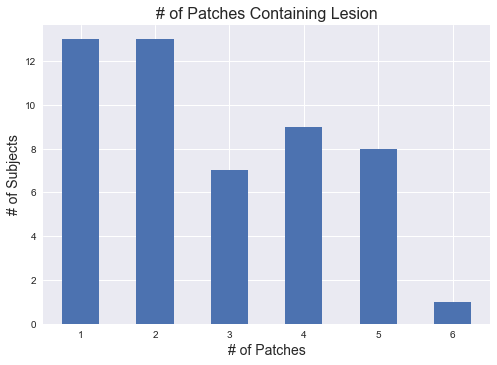

In [147]:
df_patch_count['subject']  \
    .value_counts().value_counts().sort_index()  \
    .plot(kind='bar')

plt.title('# of Patches per Subject', fontsize=16)
plt.ylabel('# of Subjects', fontsize=14)
plt.xlabel('# of Patches', fontsize=14)
plt.xticks(rotation='horizontal')
plt.show()

df_patch_count[df_patch_count['voxels_lesion'] > 0]['subject']  \
    .value_counts().value_counts().sort_index()  \
    .plot(kind='bar')

plt.title('# of Patches Containing Lesion', fontsize=16)
plt.ylabel('# of Subjects', fontsize=14)
plt.xlabel('# of Patches', fontsize=14)
plt.xticks(rotation='horizontal')
plt.show()

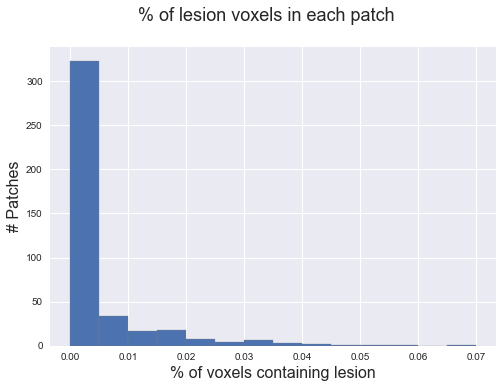

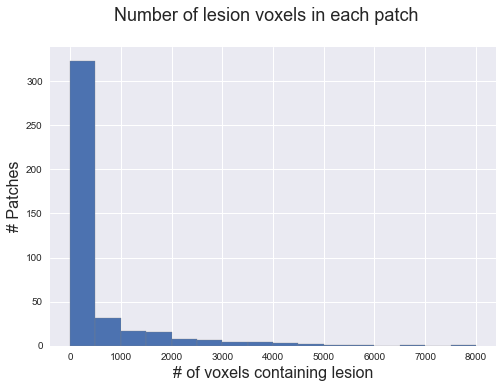

In [138]:
def plot_hist(data, bin_width, xlab='', ylab='', title='', subtitle=''):
    xmax = bin_width*np.ceil(max(data)/bin_width)
    bins = np.linspace(0, xmax, 1+int(xmax/bin_width))
    plt.hist(data, bins=bins, edgecolor='gray')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.suptitle(title, fontsize=18)
    plt.title(subtitle, fontsize=14)
    plt.show()
    
plot_hist(lesion_voxel_prop_patches, 0.005, xlab='% of voxels containing lesion', ylab='# Patches', title='% of lesion voxels in each patch')
plot_hist(lesion_voxel_count_patches, 500, xlab='# of voxels containing lesion', ylab='# Patches', title='Number of lesion voxels in each patch')

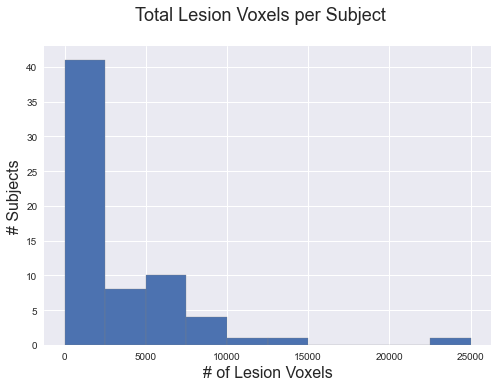

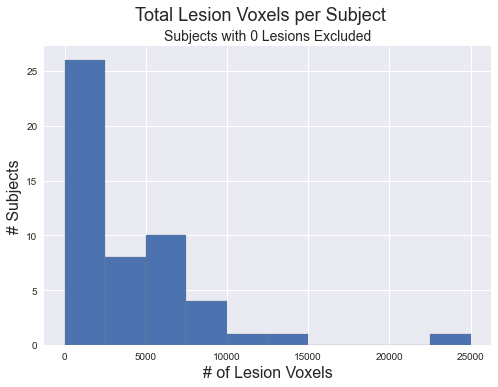

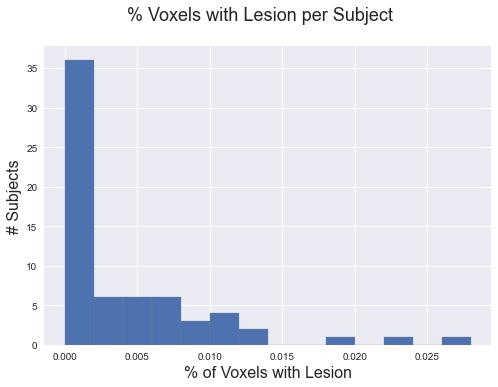

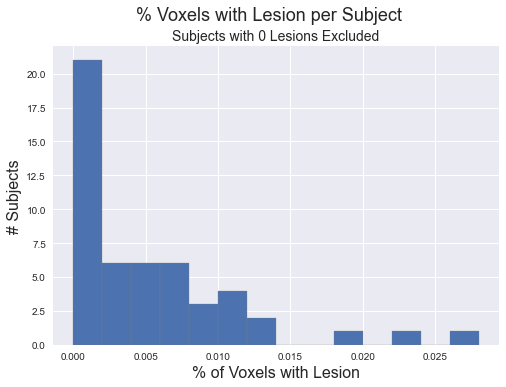

In [143]:
totals_by_subj = df_patch_count.groupby('subject')[['voxels_lesion', 'total_voxels']].sum()

totals_by_subj['prop_lesion'] = totals_by_subj['voxels_lesion']/totals_by_subj['total_voxels']

plot_hist(totals_by_subj['voxels_lesion'], bin_width=2500, 
          xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject')
plot_hist(totals_by_subj[totals_by_subj['voxels_lesion']>0]['voxels_lesion'], bin_width=2500,
        xlab='# of Lesion Voxels', ylab='# Subjects', title='Total Lesion Voxels per Subject',
         subtitle='Subjects with 0 Lesions Excluded')

# Plot Distrbution of % Lesion Voxels rather than Absolute Number of Voxels.
plot_hist(totals_by_subj['prop_lesion'], bin_width=0.002,
        xlab='% of Voxels with Lesion', ylab='# Subjects', title='% Voxels with Lesion per Subject')
plot_hist(totals_by_subj[totals_by_subj['prop_lesion']>0]['prop_lesion'], bin_width=0.002,
        xlab='% of Voxels with Lesion', ylab='# Subjects', title='% Voxels with Lesion per Subject',
         subtitle='Subjects with 0 Lesions Excluded')


Text(0.5, 0, 'Subject')

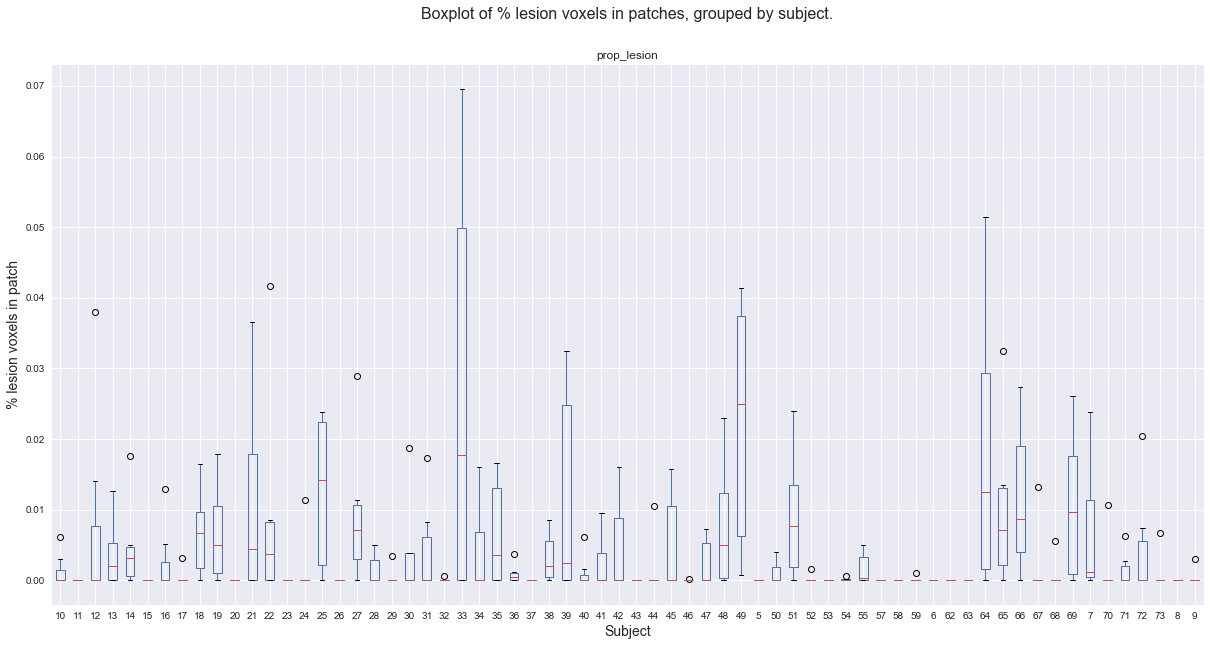

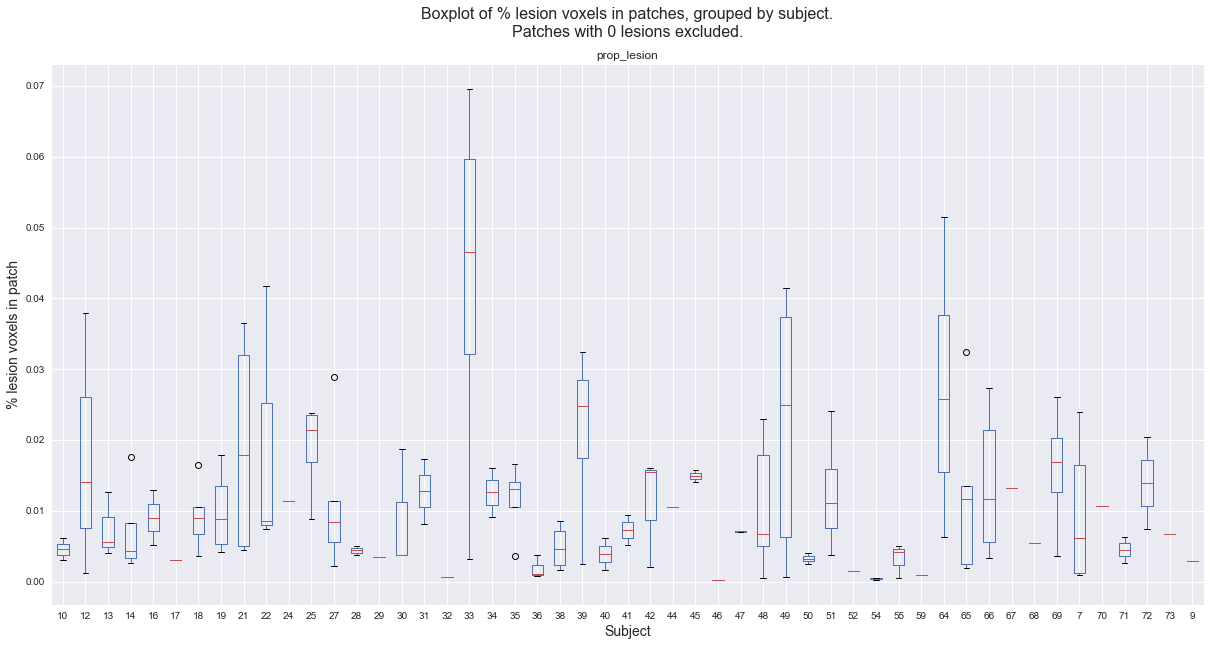

In [86]:
df_patch_count.boxplot(column='prop_lesion', by='subject', figsize=(20,10))
plt.suptitle('Boxplot of % lesion voxels in patches, grouped by subject.\n', fontsize=16)
plt.ylabel('% lesion voxels in patch', fontsize=14)
plt.xlabel('Subject', fontsize=14)

df_patch_count[df_patch_count['prop_lesion'] > 0.0].boxplot(column='prop_lesion', by='subject', figsize=(20,10))
plt.suptitle('Boxplot of % lesion voxels in patches, grouped by subject.\nPatches with 0 lesions excluded.', fontsize=16)
plt.ylabel('% lesion voxels in patch', fontsize=14)
plt.xlabel('Subject', fontsize=14)

### Summarising Intensities

#### Intensity Distribution Across All Images

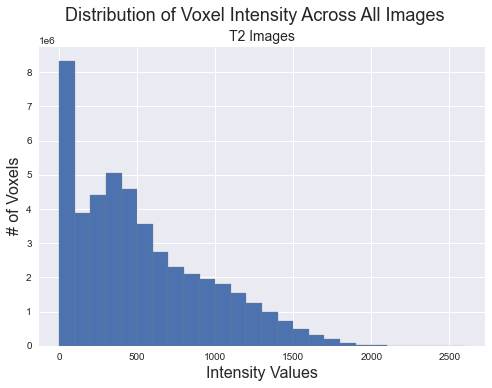

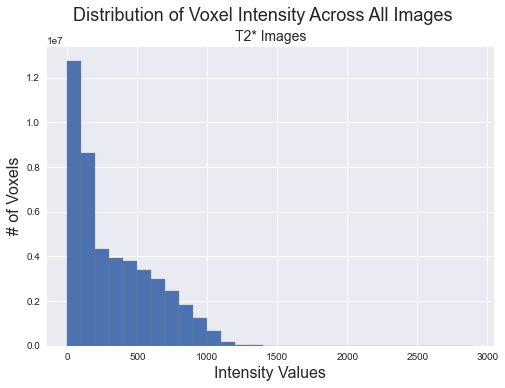

In [161]:
plot_hist(patches_t2.ravel(), bin_width=100, 
          xlab='Intensity Values', ylab='# of Voxels', title='Distribution of Voxel Intensity Across All Images', subtitle='T2 Images')
plot_hist(patches_t2s.ravel(), bin_width=100, 
          xlab='Intensity Values', ylab='# of Voxels', title='Distribution of Voxel Intensity Across All Images', subtitle='T2* Images')

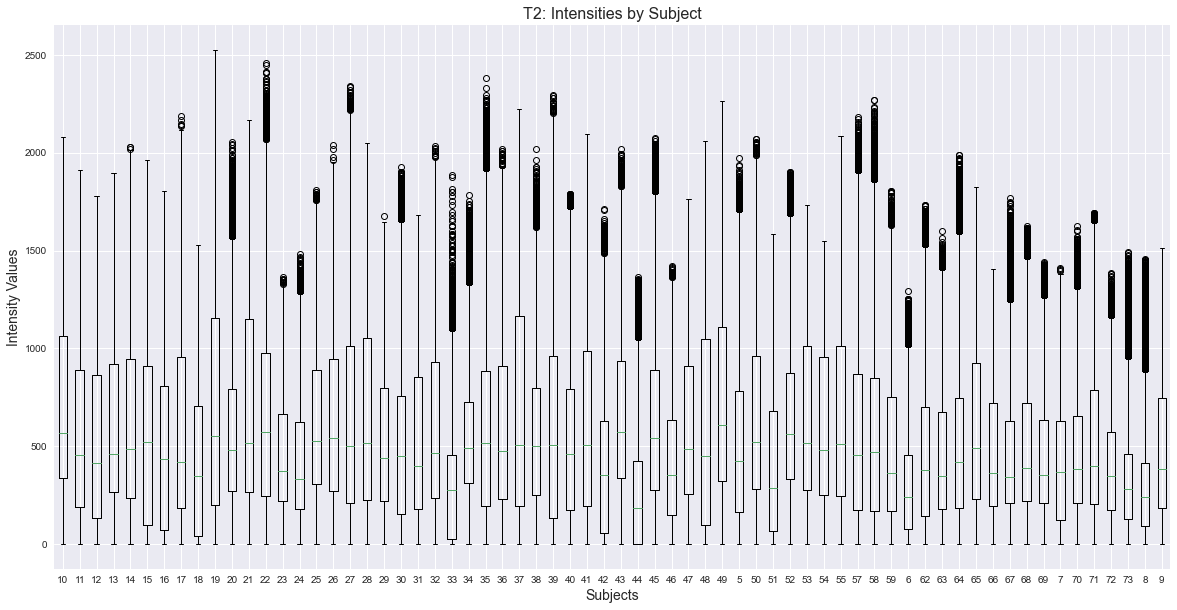

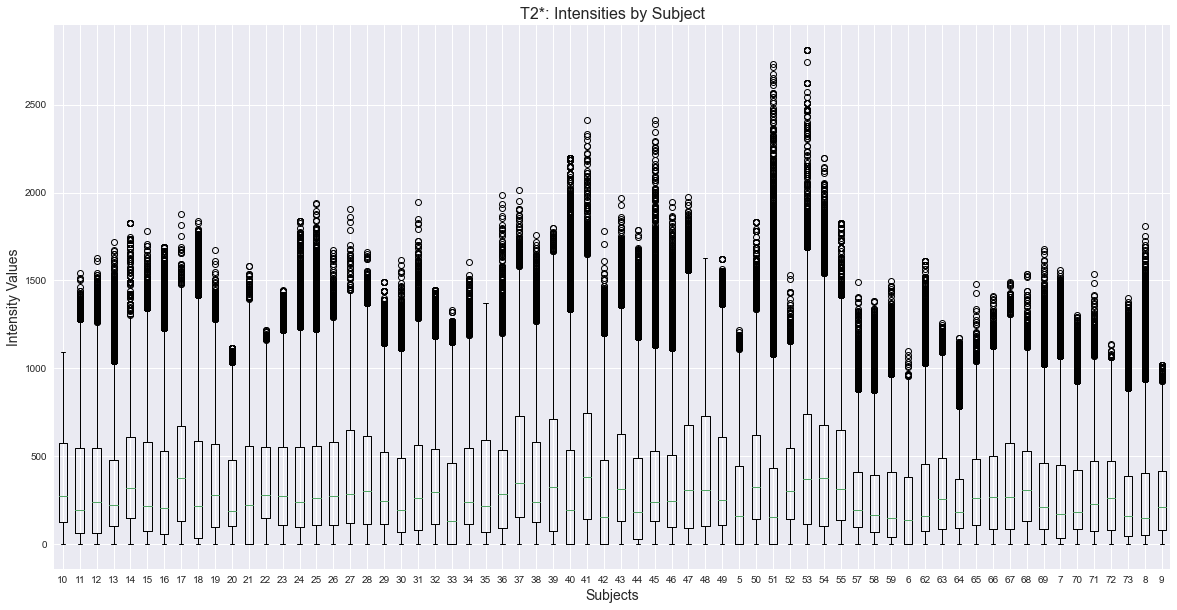

In [185]:
plt.figure(figsize=(20,10))
_ = plt.boxplot([t2_data[subj].ravel() for subj in t2_data])
_ = plt.xticks(range(1,67), labels=subjects)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Intensity Values', fontsize=14)
plt.title('T2: Intensities by Subject',fontsize=16)
plt.show()

plt.figure(figsize=(20,10))
_ = plt.boxplot([t2s_data[subj].ravel() for subj in t2s_data])
_ = plt.xticks(range(1,67), labels=subjects)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Intensity Values', fontsize=14)
plt.title('T2*: Intensities by Subject',fontsize=16)
plt.show()